## DistrictHeatingsim Model Example
This notebook demonstrates how to use Districtheatingsim heating model to simulate heating loads for multiple buildings.

## Imports
Import required libraries and set visualization defaults.

In [103]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from entise.core.generator import Generator
from entise.constants import Types
from entise.constants import Columns as Cols

## Load Data
We load building parameters from objects.csv and simulation data from the data folder.

In [104]:
# Load data
cwd = "."  # notebook runs inside examples/heat_demandlib

objects = pd.read_csv(os.path.join(cwd, "objects.csv"))

data = {}
common_data_folder = "../common_data"

for file in os.listdir(os.path.join(cwd, common_data_folder)):
    if file.endswith(".csv"):
        name = file.split(".")[0]
        data[name] = pd.read_csv(
            os.path.join(cwd, common_data_folder, file),
            parse_dates=True,
        )

print("Loaded data keys:", list(data.keys()))

Loaded data keys: ['weather']


## Instantiate and Configure Model
Initialize the time series generator and configure it with building objects.

In [105]:
gen = Generator()
gen.add_objects(objects)

summary, df = gen.generate(data, workers=1)

100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


## Results Summary
Below is a summary of the annual heating demands (in kWh/a) and peak loads (W).

In [106]:
print("Summary:")
summary_kwh = (summary / 1000).round(0).astype(int)
summary_kwh.rename(columns=lambda x: x.replace("[W]", "[kW]").replace("[Wh]", "[kWh]"), inplace=True)
print(summary_kwh.to_string())

Summary:
    heating:demand[kWh]  heating:load_max[kW]
1                  5578                     3
2                 17015                     8
3                 10735                     6
4                 11792                     5
5                 34878                    17
6                 34877                    15
7                 52314                    24
8                  5185                     2
9                 23180                     9
10               106140                    41


## Preparation of Data

In [107]:
# Pick the building to visualize (keep dtype consistent with summary index)
building_id = summary.index[0]

# Resolve object row (for dhw_share fallback)
objects_row = objects.loc[objects["id"] == building_id]
objects_row = objects_row.iloc[0] if not objects_row.empty else {}

# Resolve building dataframe
building_res = df[building_id] if building_id in df else df[next(iter(df.keys()))]
building_data = building_res[Types.HEATING].copy()

## Separation of Space Heating and DHW
Define helper function to split total heating load into space heating and DHW components.

In [108]:
def _split_space_and_dhw_W() -> tuple[pd.Series, pd.Series]:
    """Return (space_W, dhw_W) in Watts."""
    timestep_s = (building_data.index[1] - building_data.index[0]).total_seconds()

    # Preferred: explicit kWh columns
    if "load_dhw[kWh]" in building_data.columns and "load_space[kWh]" in building_data.columns:
        dhw_W = building_data["load_dhw[kWh]"] * (3_600_000.0 / timestep_s)
        space_W = building_data["load_space[kWh]"] * (3_600_000.0 / timestep_s)
        return space_W, dhw_W

    # Alternative naming
    if "load_dhw[kWh]" in building_data.columns and "load_heating[kWh]" in building_data.columns:
        dhw_W = building_data["load_dhw[kWh]"] * (3_600_000.0 / timestep_s)
        space_W = building_data["load_heating[kWh]"] * (3_600_000.0 / timestep_s)
        return space_W, dhw_W

    # Preferred: explicit W columns
    if "heating:dhw_load[W]" in building_data.columns and "heating:space_load[W]" in building_data.columns:
        dhw_W = building_data["heating:dhw_load[W]"]
        space_W = building_data["heating:space_load[W]"]
        return space_W, dhw_W

    # Fallback: derive from total + dhw_share
    if "heating:load[W]" in building_data.columns:
        total_W = building_data["heating:load[W]"]
    elif "load_total[kWh]" in building_data.columns:
        total_W = building_data["load_total[kWh]"] * (3_600_000.0 / timestep_s)
    else:
        c = next(iter([c for c in building_data.columns if pd.api.types.is_numeric_dtype(building_data[c])]))
        total_W = building_data[c] * (3_600_000.0 / timestep_s)

    dhw_share = float(objects_row.get("dhw_share", 0.0)) if isinstance(objects_row, dict) else float(objects_row.get("dhw_share", 0.0))
    dhw_W = total_W * dhw_share
    space_W = total_W - dhw_W
    return space_W, dhw_W


## Visualization of Results
Visualize heatingloads for a selected building.

In [109]:
def plot_heating_loads():
    """Heating Loads (Space heating + DHW only; NO total)"""
    fig, ax = plt.subplots(figsize=(14, 5))

    space_W, dhw_W = _split_space_and_dhw_W()
    space_kW = space_W / 1000.0
    dhw_kW = dhw_W / 1000.0

    ax.plot(building_data.index, space_kW, label="Space heating", color="tab:red")
    ax.plot(building_data.index, dhw_kW, label="DHW")

    ax.set_ylabel("Load (kW)")
    ax.set_title(f"Building ID: {building_id} - Heating Loads")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

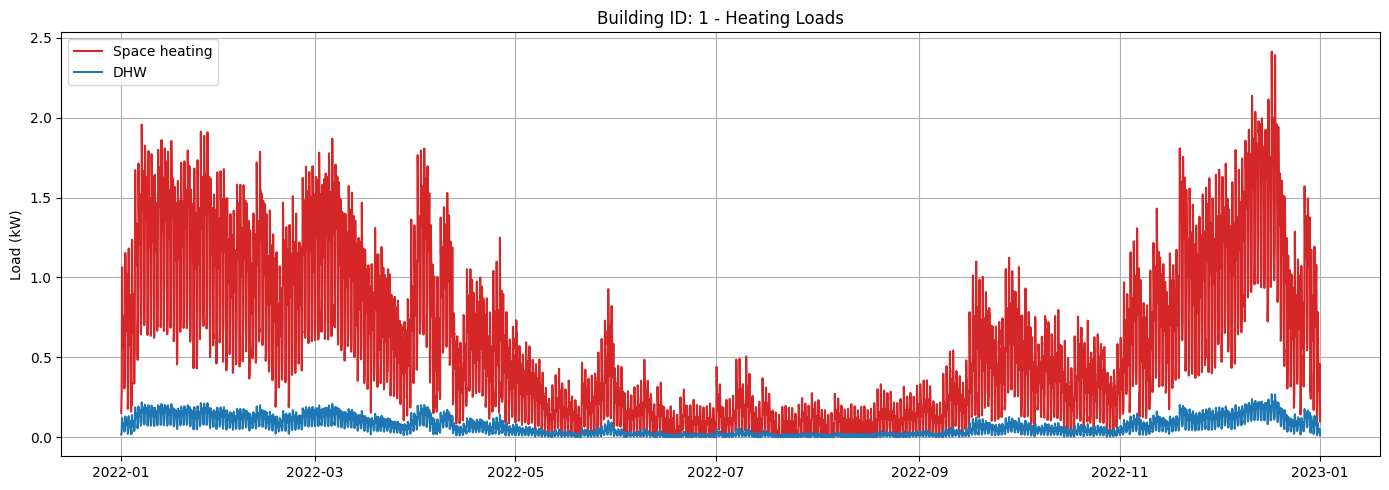

In [110]:
plot_heating_loads()

## Outdoor Temperature with Heating Loads
Next, we visualize the outdoor temperature alongside the heating loads to see how they correlate.

In [111]:
def plot_outdoor_temp_with_loads():
        """Outdoor Temperature with Space heating + DHW (NO total)"""
        fig, ax1 = plt.subplots(figsize=(15, 6))

        air_temp = data["weather"][f"{Cols.TEMP_AIR}@2m"]
        ax1.plot(
            pd.to_datetime(building_data.index, utc=True),
            air_temp,
            label="Outdoor Temp",
            color="tab:cyan",
            alpha=0.7,
        )
        ax1.set_ylabel("Outdoor Temp (°C)")
        ax1.set_ylim(air_temp.min().round() - 2, air_temp.max().round() + 2)

        space_W, dhw_W = _split_space_and_dhw_W()
        space_kW = space_W / 1000.0
        dhw_kW = dhw_W / 1000.0

        ax2 = ax1.twinx()
        ax2.plot(
            pd.to_datetime(building_data.index, utc=True),
            space_kW,
            label="Space heating",
            color="tab:red",  # requested
        )
        ax2.plot(
            pd.to_datetime(building_data.index, utc=True),
            dhw_kW,
            label="DHW",
        )

        ax2.set_ylabel("HVAC Load (kW)")
        ax2.set_ylim(0, float(max(space_kW.max(), dhw_kW.max())) * 1.1)

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

        ax1.set_title(f"Building ID: {building_id} - Outdoor Temp & Heating Loads")
        ax1.grid(True)
        fig.tight_layout()
        plt.show()

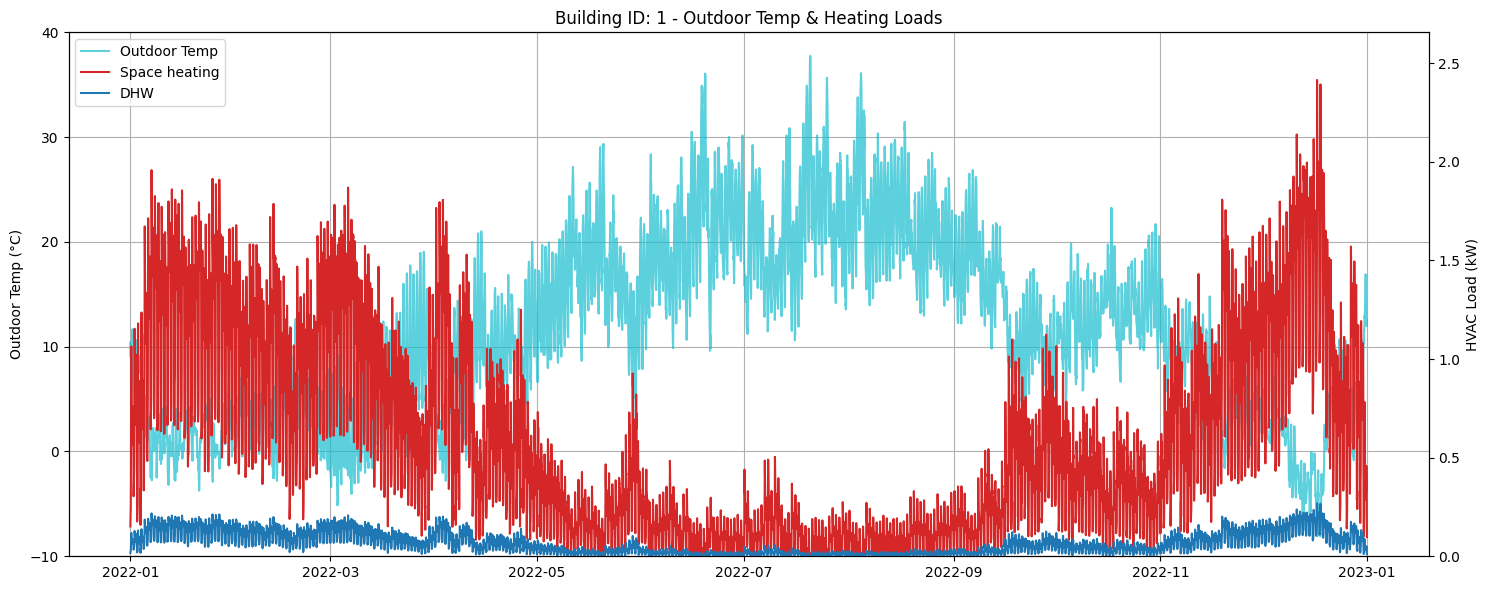

In [112]:
plot_outdoor_temp_with_loads()